CDOM Estimation Equations are applied to Landsat 5 Level 2, Acolite, and FLAASH atmospheric corrected images
- 15 images are collected to match with LTM in-situ data collection periods for Big Moose Lake
- A 100-meter buffer will be applied around Big Moose Lake lattitude and longitude coordinates and the mean of each band will be calculated for all images

# Image Preparation: Convert Single FLAASH Image into Multiple Bands

Number of bands: 6
Dimensions: 8111 x 7261


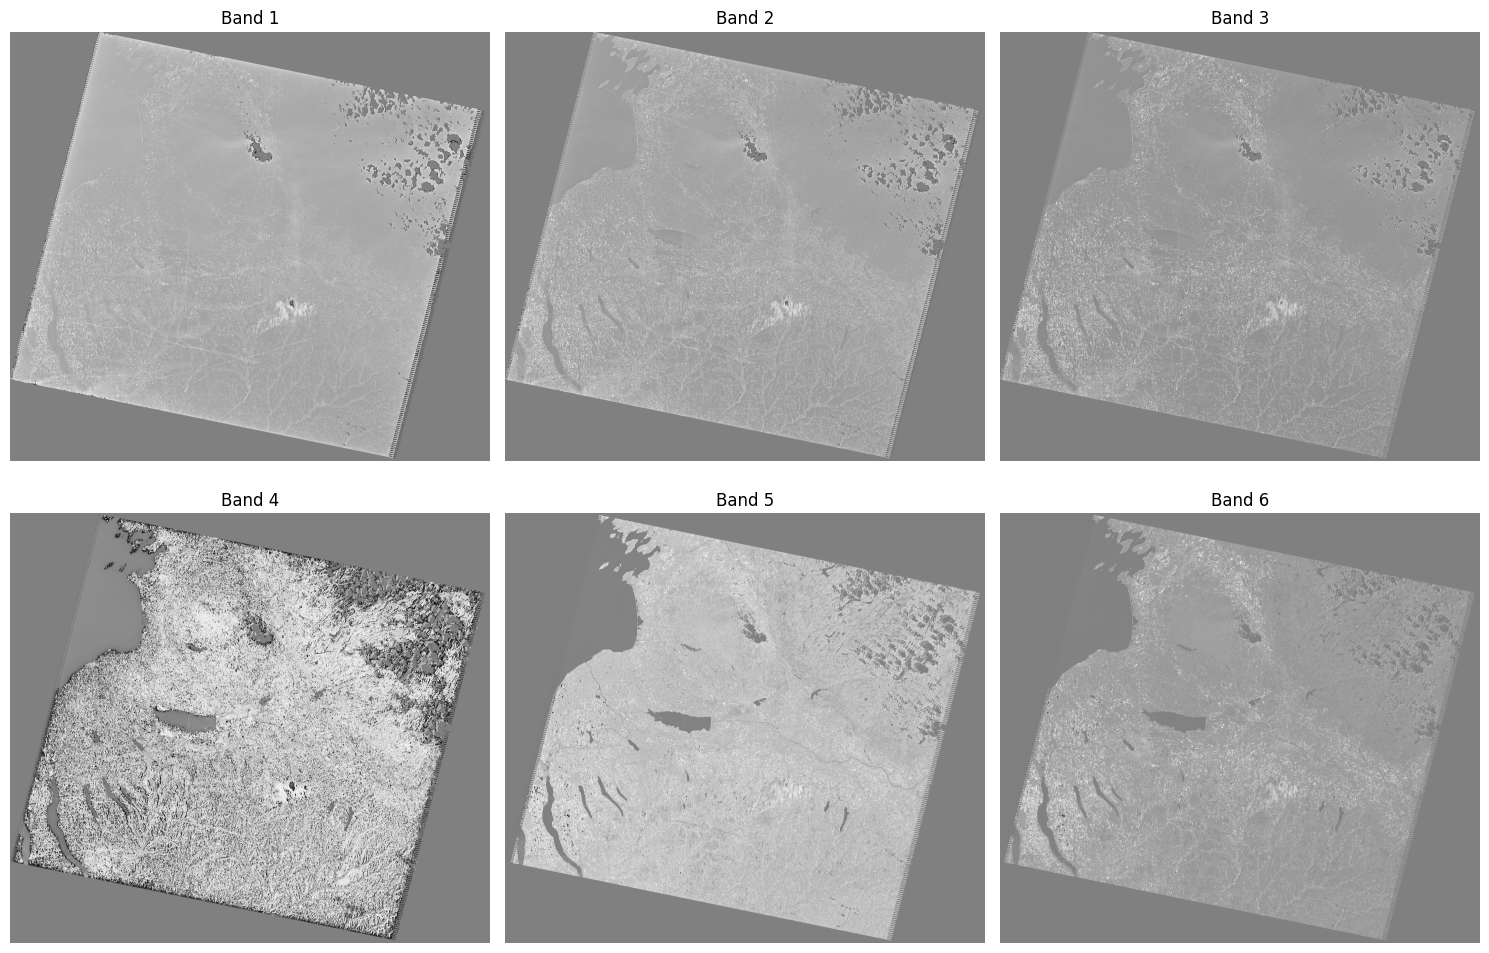

Band images have been saved successfully.


In [15]:
import rasterio
import matplotlib.pyplot as plt
import os

# Path to the GeoTIFF file
file_path = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH.tif"
# output_dir = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH"

# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the number of bands and the dimensions
    num_bands = src.count
    height = src.height
    width = src.width
    
    print(f"Number of bands: {num_bands}")
    print(f"Dimensions: {width} x {height}")
    
    # Read the entire image into a numpy array (bands, height, width)
    img = src.read()
    
    # Display and save each band separately
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    
    for i, ax in enumerate(axes.flatten()):
        if i < num_bands:
            band_img = img[i, :, :]
            
            # Display each band separately
            ax.imshow(band_img, cmap='gray')
            ax.set_title(f"Band {i+1}")
            ax.axis('off')
            
            # # Save each band as a separate TIFF file
            # output_path = os.path.join(output_dir, f"Band_{i+1}.tif")
            # with rasterio.open(
            #     output_path,
            #     'w',
            #     driver='GTiff',
            #     height=height,
            #     width=width,
            #     count=1,
            #     dtype=band_img.dtype,
            #     crs=src.crs,
            #     transform=src.transform
            # ) as dst:
            #     dst.write(band_img, 1)
    
    plt.tight_layout()
    plt.show()

# print("Band images have been saved successfully.")

# Atmospheric Corrected Images Processing (Level 1, Level 2, Acolite, and FLAASH)

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import ee
import geemap
Map= geemap.Map()

In [17]:
import geemap
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the coordinates (Big Moose Lake)
latitude = 43.82569819
longitude = -74.8592526

# Create an EE Geometry Point
lake_point = ee.Geometry.Point(longitude, latitude)

# Create a 100-meter buffered box around the lake point
buffered_polygon = lake_point.buffer(100)

# Convert EE Geometry to a Feature for visualization
buffered_feature = ee.Feature(buffered_polygon, {'type': 'buffer'})

# Convert EE Feature to a GeoJSON for visualization in geemap
buffered_geojson = buffered_feature.geometry().getInfo()

# Initialize the map centered around the lake point
center = [latitude, longitude]
m = geemap.Map(center=center, zoom=14)

# Add the buffered polygon to the map
m.add_geojson(buffered_geojson, layer_name='Buffered Polygon', style={'color': 'black', 'fillOpacity': 0.1})

# Display the map
m

Map(center=[43.82569819, -74.8592526], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

## Landsat 5 Level 1

### LT05_L1TP_015030_19850713_20200918_02_T1

In [20]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for all bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1\LT05_L1TP_015030_19850713_20200918_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the image was taken
image_date = "1985-07-13"

# Initialize empty DataFrame for means
LT5_L1 = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    LT5_L1[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        LT5_L1[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    LT5_L1[band] = LT5_L1[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        LT5_L1[band] = LT5_L1[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
means = {f'{band}_mean': np.mean(LT5_L1[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the means dictionary
means['DATE'] = image_date

# Convert the means dictionary to a DataFrame and assign it to LT5_L1
LT5_L1 = pd.DataFrame([means])

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.01,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13


### LT05_L1TP_015030_19860716_20200917_02_T1

In [21]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1\LT05_L1TP_015030_19860716_20200917_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1986-07-16"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.01000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.01032,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16


### LT05_L1TP_015030_19890724_20200916_02_T1

In [22]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1\LT05_L1TP_015030_19890724_20200916_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1989-07-24"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24


### LT05_L1TP_015030_19900727_20200916_02_T1

In [23]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1\LT05_L1TP_015030_19900727_20200916_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1990-07-27"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27


### LT05_L1TP_015030_19910730_20200915_02_T1

In [24]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1\LT05_L1TP_015030_19910730_20200915_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1991-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30


### LT05_L1TP_015030_19960711_20200911_02_T1

In [25]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1\LT05_L1TP_015030_19960711_20200911_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1996-07-11"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11


### LT05_L1TP_015030_19970730_20200910_02_T1

In [26]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1\LT05_L1TP_015030_19970730_20200910_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "1997-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30


### LT05_L1TP_015030_20010709_20200906_02_T1

In [27]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1\LT05_L1TP_015030_20010709_20200906_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2001-07-09"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09


### LT05_L1TP_015030_20030715_20200905_02_T1

In [29]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1\LT05_L1TP_015030_20030715_20200905_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2003-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15


### LT05_L1TP_015030_20050704_20200902_02_T1

In [30]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1\LT05_L1TP_015030_20050704_20200902_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2005-07-04"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


### LT05_L1TP_015030_20060707_20200831_02_T1

In [32]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1\LT05_L1TP_015030_20060707_20200831_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2006-07-07"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


### LT05_L1TP_015030_20080712_20200829_02_T1

In [33]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1\LT05_L1TP_015030_20080712_20200829_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2008-07-12"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


### LT05_L1TP_015030_20090715_20200827_02_T1

In [34]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1\LT05_L1TP_015030_20090715_20200827_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2009-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


### LT05_L1TP_015030_20100702_20200824_02_T1

In [35]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1\LT05_L1TP_015030_20100702_20200824_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2010-07-02"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


### LT05_L1TP_015030_20110705_20200822_02_T1

In [36]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B1.TIF"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B2.TIF"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B3.TIF"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B4.TIF"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B5.TIF"
b6_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B6.TIF"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1\LT05_L1TP_015030_20110705_20200822_02_T1_B7.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Date the new image was taken
image_date = "2011-07-05"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    new_means_df[band] = new_means_df[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        new_means_df[band] = new_means_df[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1 = pd.concat([LT5_L1, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


In [37]:
# Export the resulting DataFrame to a CSV file
output_csv = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_Big_Moose_Lake_100m_15_images.csv"
LT5_L1.to_csv(output_csv, index=False)

In [50]:
LT5_L1

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


## Landsat 5 Level 2 (USGS Atmospheric Corrected)

In [47]:
import ee
import geemap
import pandas as pd

# Initialize Earth Engine
ee.Initialize()

# Define the Landsat 5 bands and their corresponding standard names
LC5_BANDS = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL']
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp', 'QA']

# Define the specified dates
specified_dates = [
    '1985-07-13', '1986-07-16', '1989-07-24', '1990-07-27', '1991-07-30',
    '1996-07-11', '1997-07-30', '2001-07-09', '2003-07-15', '2005-07-04',
    '2006-07-07', '2008-07-12', '2009-07-15', '2010-07-02', '2011-07-05'
]

# Convert specified dates to datetime format
specified_dates = pd.to_datetime(specified_dates)

# Define the coordinates for the lake
latitude = 43.82569819
longitude = -74.8592526

# Create a geometry point for the lake and a buffer around it
lake_point = ee.Geometry.Point(longitude, latitude).buffer(100)

# Define a function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    waterMask = image.select('QA_PIXEL').eq(5440).Or(image.select('QA_PIXEL').eq(5504))
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(qaMask).updateMask(saturationMask).updateMask(waterMask)

# Define a function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img):
    # Combine reducers with shared inputs
    reducers = ee.Reducer.mean().combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True)
    # Use the combined reducer to get the mean and SD of the image.
    reflectance_values = img.reduceRegion(reducer=reducers, geometry=lake_point, scale=30, bestEffort=True)
    # Set properties on the image
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the reflectance data
reflectance_data = []

# Loop through each specified date
for date in specified_dates:
    # Create a 7-day window around the current date
    date_window_start = date - pd.Timedelta(days=1)
    date_window_end = date + pd.Timedelta(days=1)

    # Retrieve Landsat 5 imagery for the specific date range
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterBounds(lake_point) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
        .filterDate(date_window_start, date_window_end) \
        .map(maskL457sr) \
        .select(LC5_BANDS, STD_NAMES)

    # Map the reflectance function over the Landsat 5 ImageCollection
    map_reflectance = l5.map(reflectance)

    # Reduce the mapped image collection to get reflectance values
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a list and append to the reflectance_data list
    reflectance_data.extend(list_reflectance.getInfo())

# Convert the reflectance data to a pandas DataFrame
df_reflectance = pd.DataFrame(reflectance_data, columns=['DATE_SMP', 'reflectance'])
df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})

# Unpack the 'reflectance' dictionary and create separate columns for each band
df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                            df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_reflectance.sort_values(by='DATE_SMP', inplace=True)

# Display the resulting DataFrame
df_reflectance

,DATE_SMP,QA_mean,QA_stdDev,blue_mean,blue_stdDev,green_mean,green_stdDev,nir_mean,nir_stdDev,red_mean,red_stdDev,swir1_mean,swir1_stdDev,swir2_mean,swir2_stdDev,temp_mean,temp_stdDev
0,1985-07-13 15:14:47,5504.000000,0.000000,0.022774,0.003466,0.028069,0.003293,0.035332,0.004271,0.022139,0.004292,0.015316,0.005029,0.011471,0.003679,19.926004,0.229088
1,1985-07-13 15:15:11,5503.949097,9.433955,0.022800,0.003464,0.028063,0.003289,0.035270,0.004257,0.022156,0.004328,0.015221,0.005029,0.011416,0.003837,19.926004,0.229088
2,1986-07-16 15:07:34,5502.298375,13.189146,0.017336,0.001611,0.020328,0.001688,0.026526,0.001962,0.011075,0.001366,0.003081,0.002677,0.001285,0.002480,21.402521,0.309231
3,1986-07-16 15:07:58,5502.298375,13.189146,0.017317,0.001640,0.020293,0.001737,0.026722,0.001934,0.011105,0.001363,0.003182,0.002706,0.001117,0.002532,21.143194,0.000000
4,1989-07-24 15:12:03,5440.000000,0.000000,0.034887,0.002118,0.039042,0.002777,0.074229,0.002202,0.025570,0.001946,0.005861,0.002497,0.002015,0.002228,22.541048,0.289377
5,1989-07-24 15:12:27,5440.000000,0.000000,0.034895,0.002117,0.038993,0.002775,0.073952,0.002227,0.025523,0.001943,0.005730,0.002498,0.002019,0.002224,22.396983,0.334590
6,1990-07-27 15:04:55,5504.000000,0.000000,0.029283,0.003223,0.030808,0.002154,0.035706,0.002010,0.022505,0.001744,0.010370,0.003113,0.006134,0.002725,21.794808,0.290924
7,1990-07-27 15:05:19,5504.000000,0.000000,0.028008,0.003380,0.029712,0.002097,0.035415,0.001963,0.021784,0.001756,0.010409,0.003016,0.006383,0.002957,21.820344,0.280382
8,1991-07-30 15:08:19,5475.821384,31.928810,0.021947,0.001961,0.027382,0.002301,0.039254,0.001782,0.019994,0.002876,0.014470,0.002323,0.009714,0.002082,22.004458,0.296921
9,1991-07-30 15:08:43,5475.821384,31.928810,0.021020,0.001928,0.024115,0.002161,0.039529,0.001748,0.018690,0.002598,0.014574,0.002214,0.009748,0.002091,21.940913,0.265728


In [48]:
# Add a column with date only (without time)
df_reflectance['DATE_ONLY'] = df_reflectance['DATE_SMP'].dt.date

# Sort the DataFrame by 'DATE_SMP'
df_reflectance.sort_values(by='DATE_SMP', inplace=True)

# Group by 'DATE_ONLY' and keep the last occurrence within each group
df_reflectance = df_reflectance.groupby('DATE_ONLY').head(1) # tail(1) - for second occurance

# Drop the 'DATE_ONLY' column as it's no longer needed
df_reflectance.drop(columns=['DATE_ONLY'], inplace=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_reflectance.sort_values(by='DATE_SMP', inplace=True)

df_reflectance

,DATE_SMP,QA_mean,QA_stdDev,blue_mean,blue_stdDev,green_mean,green_stdDev,nir_mean,nir_stdDev,red_mean,red_stdDev,swir1_mean,swir1_stdDev,swir2_mean,swir2_stdDev,temp_mean,temp_stdDev
0,1985-07-13 15:14:47,5504.000000,0.000000,0.022774,0.003466,0.028069,0.003293,0.035332,0.004271,0.022139,0.004292,0.015316,0.005029,0.011471,0.003679,19.926004,0.229088
2,1986-07-16 15:07:34,5502.298375,13.189146,0.017336,0.001611,0.020328,0.001688,0.026526,0.001962,0.011075,0.001366,0.003081,0.002677,0.001285,0.002480,21.402521,0.309231
4,1989-07-24 15:12:03,5440.000000,0.000000,0.034887,0.002118,0.039042,0.002777,0.074229,0.002202,0.025570,0.001946,0.005861,0.002497,0.002015,0.002228,22.541048,0.289377
6,1990-07-27 15:04:55,5504.000000,0.000000,0.029283,0.003223,0.030808,0.002154,0.035706,0.002010,0.022505,0.001744,0.010370,0.003113,0.006134,0.002725,21.794808,0.290924
8,1991-07-30 15:08:19,5475.821384,31.928810,0.021947,0.001961,0.027382,0.002301,0.039254,0.001782,0.019994,0.002876,0.014470,0.002323,0.009714,0.002082,22.004458,0.296921
10,1996-07-11 14:59:02,5504.000000,0.000000,0.017613,0.002377,0.021821,0.002416,0.030595,0.002677,0.018721,0.002569,0.012413,0.002487,0.008904,0.003024,18.481752,0.155930
12,1997-07-30 15:15:50,5504.000000,0.000000,0.013013,0.002085,0.014947,0.002923,0.023236,0.001987,0.011331,0.001893,0.006840,0.002162,0.005250,0.003207,20.622647,0.250971
14,2001-07-09 15:25:15,5504.000000,0.000000,0.020192,0.001779,0.023972,0.001332,0.027692,0.001739,0.017121,0.002149,0.009108,0.003067,0.007272,0.002595,19.705437,0.442931
16,2003-07-15 15:21:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2005-07-04 15:32:29,5440.000000,0.000000,0.066125,0.003900,0.067932,0.003135,0.123528,0.002769,0.053533,0.002687,0.033565,0.005308,0.023499,0.004455,22.541042,0.000973


In [49]:
# Export the resulting DataFrame to a CSV file
output_csv = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L2_Big_Moose_Lake_100m_15_images.csv"
df_reflectance.to_csv(output_csv, index=False)

## Landsat 5 Level 1 Acolite (Atmospheric Corrected)

In [57]:
# To reset dataframe, run this line of code
LT5_L1_acolite = pd.DataFrame()

### LT05_L1TP_015030_19850713_20200918_02_T1_acolite

In [58]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd
import rasterio.warp

# Define file paths for all bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_acolite\L5_TM_1985_07_13_15_15_11_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the image was taken
image_date = "1985-07-13"

# Initialize empty DataFrame for means
LT5_L1_acolite = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    LT5_L1_acolite[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        LT5_L1_acolite[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
means = {f'{band}_mean': np.mean(LT5_L1_acolite[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the means dictionary
means['DATE'] = image_date

# Convert the means dictionary to a DataFrame and assign it to LT5_L1_acolite
LT5_L1_acolite = pd.DataFrame([means])

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13


### LT05_L1TP_015030_19860716_20200917_02_T1_acolite

In [59]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_acolite\L5_TM_1986_07_16_15_07_58_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1986-07-16"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16


### LT05_L1TP_015030_19890724_20200916_02_T1_acolite

In [60]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_acolite\L5_TM_1989_07_24_15_12_27_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1989-07-24"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24


### LT05_L1TP_015030_19900727_20200916_02_T1_acolite

In [61]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_acolite\L5_TM_1990_07_27_15_05_19_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1990-07-27"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27


### LT05_L1TP_015030_19910730_20200915_02_T1_acolite

In [62]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_acolite\L5_TM_1991_07_30_15_08_43_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1991-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30


### LT05_L1TP_015030_19960711_20200911_02_T1_acolite

In [63]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_acolite\L5_TM_1996_07_11_14_59_26_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1996-07-11"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11


### LT05_L1TP_015030_19970730_20200910_02_T1_acolite

In [64]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_acolite\L5_TM_1997_07_30_15_16_14_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1997-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30


### LT05_L1TP_015030_20010709_20200906_02_T1_acolite

In [65]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_acolite\L5_TM_2001_07_09_15_25_39_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2001-07-09"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09


### LT05_L1TP_015030_20030715_20200905_02_T1_acolite

In [66]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_acolite\L5_TM_2003_07_15_15_21_38_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2003-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15


### LT05_L1TP_015030_20050704_20200902_02_T1_acolite

In [67]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_acolite\L5_TM_2005_07_04_15_32_53_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2005-07-04"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


In [68]:
### LT05_L1TP_015030_20060707_20200831_02_T1_acolite

In [69]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_acolite\L5_TM_2006_07_07_15_38_11_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2006-07-07"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


### LT05_L1TP_015030_20080712_20200829_02_T1_acolite

In [70]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_acolite\L5_TM_2008_07_12_15_32_10_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2008-07-12"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


### LT05_L1TP_015030_20090715_20200827_02_T1_acolite

In [71]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_acolite\L5_TM_2009_07_15_15_34_06_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2009-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


### LT05_L1TP_015030_20100702_20200824_02_T1_acolite

In [72]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_acolite\L5_TM_2010_07_02_15_35_48_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2010-07-02"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


### LT05_L1TP_015030_20110705_20200822_02_T1_acolite

In [73]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_486.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_571.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_660.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_839.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_1678.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_acolite\L5_TM_2011_07_05_15_34_27_015030_L2R_rhos_2217.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2011-07-05"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1 DataFrame
LT5_L1_acolite = pd.concat([LT5_L1_acolite, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


In [74]:
# Export the resulting DataFrame to a CSV file
output_csv = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_acolite_Big_Moose_Lake_100m_15_images.csv"
LT5_L1_acolite.to_csv(output_csv, index=False)

In [75]:
LT5_L1_acolite

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


## Landsat 5 Level 1 FLAASH (Atmospheric Corrected)

### LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH

In [82]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for all bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19850713_20200918_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the image was taken
image_date = "1985-07-13"

# Initialize empty DataFrame for means
LT5_L1_FLAASH = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    LT5_L1_FLAASH[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        LT5_L1_FLAASH[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
LT5_L1_FLAASH = LT5_L1_FLAASH / 32768.0
# LT5_L1_FLAASH = (LT5_L1_FLAASH + 32768) / 65535.0  # Scale to range 0-1

# Calculate mean values for each band
means = {f'{band}_mean': np.mean(LT5_L1_FLAASH[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the means dictionary
means['DATE'] = image_date

# Convert the means dictionary to a DataFrame and assign it to LT5_L1_FLAASH
LT5_L1_FLAASH = pd.DataFrame([means])

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13


### LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH

In [84]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19860716_20200917_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1986-07-16"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0
# new_means_df = (new_means_df + 32768) / 65535.0  # Scale to range 0-1

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16


### LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH

In [85]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19890724_20200916_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1989-07-24"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24


### LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH

In [86]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19900727_20200916_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1990-07-27"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27


### LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH

In [87]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19910730_20200915_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1991-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30


### LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH

In [89]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19960711_20200911_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1996-07-11"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11


### LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH

In [90]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_19970730_20200910_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "1997-07-30"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30


### LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH

In [91]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20010709_20200906_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2001-07-09"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09


### LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH

In [92]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20030715_20200905_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2003-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15


### LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH

In [93]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20050704_20200902_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2005-07-04"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


### LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH

In [95]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20060707_20200831_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2006-07-07"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


### LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH

In [97]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20080712_20200829_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2008-07-12"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


### LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH

In [98]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20090715_20200827_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2009-07-15"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


### LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH

In [99]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20100702_20200824_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2010-07-02"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


### LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH

In [100]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import numpy as np
import pandas as pd

# Define file paths for the new set of bands
b1_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_1.tif"
b2_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_2.tif"
b3_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_3.tif"
b4_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_4.tif"
b5_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_5.tif"
b7_tiff = r"D:\Aisha\LT05_L1TP_015030\LT05_L1TP_015030_20110705_20200822_02_T1_FLAASH\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Date the new image was taken
image_date = "2011-07-05"

# Initialize empty DataFrame for new means
new_means_df = pd.DataFrame()

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Convert the latitude and longitude to the coordinate reference system of the image
    latitude = 43.82569819
    longitude = -74.8592526
    point = Point(longitude, latitude)
    point_transformed = rasterio.warp.transform_geom('EPSG:4326', src.crs, point.__geo_interface__)

    # Create a buffer around the point
    buffer_distance = 100  # Define buffer distance in meters
    buffer = Point(point_transformed['coordinates']).buffer(buffer_distance)

    # Create a mask for the buffer
    mask = geometry_mask([buffer], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_buffer = band_data[mask]

    # Add the values as a new column in the DataFrame
    new_means_df[column_names[tiff_files[0]]] = values_within_buffer

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_buffer = band_data[mask]

        # Add the values as a new column in the DataFrame
        new_means_df[column_names[tiff_file]] = values_within_buffer

# Divide all band values by 32768.0 before calculating the mean
new_means_df = new_means_df / 32768.0

# Calculate mean values for each band
new_means = {f'{band}_mean': np.mean(new_means_df[band]) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']}

# Add the date to the new means dictionary
new_means['DATE'] = image_date

# Convert the new means dictionary to a DataFrame
new_means_df = pd.DataFrame([new_means])

# Append the new means DataFrame to the original LT5_L1_FLAASH DataFrame
LT5_L1_FLAASH = pd.concat([LT5_L1_FLAASH, new_means_df], ignore_index=True)

# Print the resulting DataFrame
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


In [101]:
# Export the resulting DataFrame to a CSV file
output_csv = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_FLAASH_Big_Moose_Lake_100m_15_images.csv"
LT5_L1_FLAASH.to_csv(output_csv, index=False)

In [102]:
LT5_L1_FLAASH

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


# Atmospheric Correction CDOM vs LTM in-situ CDOM Data

In [103]:
# Load csv files with band data for Big Moose Lake (15 images)
LT5_L1_df = pd.read_csv(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_Big_Moose_Lake_100m_15_images.csv")
LT5_L1_df

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,DATE
0,-0.021222,-0.010000,-0.002162,0.006487,-0.001931,123.742857,-0.000665,1985-07-13
1,-0.021313,-0.010320,-0.002712,0.006080,-0.002060,123.000000,-0.000710,1986-07-16
2,-0.017340,-0.007198,-0.000252,0.008986,-0.001969,127.457143,-0.000696,1989-07-24
3,-0.019927,-0.009254,-0.001680,0.006717,-0.001965,125.485714,-0.000683,1990-07-27
4,-0.021511,-0.010182,-0.002397,0.006596,-0.001948,124.228571,-0.000676,1991-07-30
5,-0.022850,-0.011005,-0.002489,0.006172,-0.001969,118.914286,-0.000678,1996-07-11
6,-0.023219,-0.011317,-0.002965,0.005725,-0.002032,124.342857,-0.000695,1997-07-30
7,-0.022363,-0.010670,-0.002434,0.006120,-0.001998,121.885714,-0.000685,2001-07-09
8,-0.020810,-0.009657,-0.001544,0.006860,-0.001955,125.857143,-0.000675,2003-07-15
9,-0.016350,-0.005744,0.001811,0.011738,-0.001654,128.000000,-0.000603,2005-07-04


In [105]:
LT5_L2_df = pd.read_csv(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L2_Big_Moose_Lake_100m_15_images.csv")
LT5_L2_df

,DATE_SMP,QA_mean,QA_stdDev,blue_mean,blue_stdDev,green_mean,green_stdDev,nir_mean,nir_stdDev,red_mean,red_stdDev,swir1_mean,swir1_stdDev,swir2_mean,swir2_stdDev,temp_mean,temp_stdDev
0,1985-07-13 15:14:47,5504.000000,0.000000,0.022774,0.003466,0.028069,0.003293,0.035332,0.004271,0.022139,0.004292,0.015316,0.005029,0.011471,0.003679,19.926004,0.229088
1,1986-07-16 15:07:34,5502.298375,13.189146,0.017336,0.001611,0.020328,0.001688,0.026526,0.001962,0.011075,0.001366,0.003081,0.002677,0.001285,0.002480,21.402521,0.309231
2,1989-07-24 15:12:03,5440.000000,0.000000,0.034887,0.002118,0.039042,0.002777,0.074229,0.002202,0.025570,0.001946,0.005861,0.002497,0.002015,0.002228,22.541048,0.289377
3,1990-07-27 15:04:55,5504.000000,0.000000,0.029283,0.003223,0.030808,0.002154,0.035706,0.002010,0.022505,0.001744,0.010370,0.003113,0.006134,0.002725,21.794808,0.290924
4,1991-07-30 15:08:19,5475.821384,31.928810,0.021947,0.001961,0.027382,0.002301,0.039254,0.001782,0.019994,0.002876,0.014470,0.002323,0.009714,0.002082,22.004458,0.296921
5,1996-07-11 14:59:02,5504.000000,0.000000,0.017613,0.002377,0.021821,0.002416,0.030595,0.002677,0.018721,0.002569,0.012413,0.002487,0.008904,0.003024,18.481752,0.155930
6,1997-07-30 15:15:50,5504.000000,0.000000,0.013013,0.002085,0.014947,0.002923,0.023236,0.001987,0.011331,0.001893,0.006840,0.002162,0.005250,0.003207,20.622647,0.250971
7,2001-07-09 15:25:15,5504.000000,0.000000,0.020192,0.001779,0.023972,0.001332,0.027692,0.001739,0.017121,0.002149,0.009108,0.003067,0.007272,0.002595,19.705437,0.442931
8,2003-07-15 15:21:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2005-07-04 15:32:29,5440.000000,0.000000,0.066125,0.003900,0.067932,0.003135,0.123528,0.002769,0.053533,0.002687,0.033565,0.005308,0.023499,0.004455,22.541042,0.000973


In [106]:
LT5_L1_acolite_df = pd.read_csv(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_acolite_Big_Moose_Lake_100m_15_images.csv")
LT5_L1_acolite_df

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.008598,0.015052,0.008547,0.022076,0.002033,0.000489,1985-07-13
1,0.018556,0.021770,0.012279,0.026062,0.001710,-0.000240,1986-07-16
2,0.060601,0.058442,0.042531,0.074984,0.006089,-0.000045,1989-07-24
3,0.030071,0.030615,0.020826,0.031467,0.003520,0.000193,1990-07-27
4,0.009988,0.016526,0.008858,0.027836,0.003369,0.000118,1991-07-30
5,0.006303,0.011646,0.007953,0.020697,0.002454,0.000516,1996-07-11
6,0.007013,0.013538,0.007371,0.018605,0.002136,0.000754,1997-07-30
7,0.009985,0.015301,0.008830,0.019499,0.001613,0.000809,2001-07-09
8,0.029767,0.029051,0.020043,0.032229,0.005161,0.002601,2003-07-15
9,0.055255,0.052392,0.036054,0.089596,0.007558,0.000000,2005-07-04


In [107]:
LT5_L1_FLAASH_df = pd.read_csv(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_FLAASH_Big_Moose_Lake_100m_15_images.csv")
LT5_L1_FLAASH_df

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04


In [148]:
LT5_L1_FLAASH_rescaled_df = pd.read_csv(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT5_L1_FLAASH_Big_Moose_Lake_100m_15_images_rescaled.csv")
LT5_L1_FLAASH_rescaled_df

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE
0,0.674011,0.595991,0.566925,0.438097,0.508525,0.515211,1985-07-13
1,0.656209,0.574553,0.536332,0.434356,0.491146,0.498654,1986-07-16
2,0.720814,0.648329,0.608389,0.537188,0.503447,0.503485,1989-07-24
3,0.713836,0.614343,0.571218,0.462919,0.504319,0.508040,1990-07-27
4,0.667952,0.592074,0.558247,0.453884,0.508280,0.511914,1991-07-30
5,0.650690,0.578010,0.555845,0.437596,0.504646,0.510751,1996-07-11
6,0.632545,0.564936,0.536699,0.427723,0.496268,0.504366,1997-07-30
7,0.655858,0.577749,0.548967,0.422255,0.498679,0.507314,2001-07-09
8,0.673759,0.585556,0.552867,0.464765,0.504736,0.509840,2003-07-15
9,0.709354,0.665223,0.629841,0.673556,0.552855,0.538052,2005-07-04


In [114]:
LTM_insitu_df = pd.read_excel(r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LTM_Data_2023_3_9.xlsx")
LTM_insitu_df = LTM_insitu_df[LTM_insitu_df['SITE_ID'] == '1A1-103']
LTM_insitu_df = LTM_insitu_df[LTM_insitu_df['DATE_SMP'].dt.month == 7]
LTM_insitu_df = LTM_insitu_df[LTM_insitu_df['DATE_SMP'].dt.year <= 2011]
LTM_insitu_df = LTM_insitu_df[LTM_insitu_df['DATE_SMP'].dt.year >= 1985]

years_to_remove = [1984, 1987, 1988, 1992, 1993, 1994, 1995, 1998, 1999, 2000, 2002, 2004, 2007]
LTM_insitu_df = LTM_insitu_df[~LTM_insitu_df['DATE_SMP'].dt.year.isin(years_to_remove)]

LTM_insitu_df

,SITE_ID,PROGRAM_ID,DATE_SMP,month,SAMPLE_LOCATION,SAMPLE_TYPE,WATERBODY_TYPE,SAMPLE_DEPTH,TIME_SMP,ANC_UEQ_L,...,N_TD_UEQ_L,PH_EQ,PH_FLD,PH_LAB,PH_STVL,P_TL_UEQ_L,SECCHI_M,SIO2_MG_L,SO4_UEQ_L,WTEMP_DEG_C
489,1A1-103,LTM_ALTM,2009-07-07,7.0,EPI,Regular,Lake,0.0,1235,18.840,...,NaN,6.01,NaN,5.921,NaN,2.25,NaN,3.170000,65.87568,NaN
5018,1A1-103,LTM_ALTM,1989-07-11,7.0,OUT,Regular,Lake,NaN,NaN,-1.200,...,NaN,NaN,5.48,NaN,NaN,NaN,NaN,3.460000,112.40000,21.0
5397,1A1-103,LTM_ALTM,2003-07-01,7.0,EPI,Regular,Lake,0.0,1145,9.580,...,NaN,5.65,NaN,5.666,NaN,NaN,NaN,3.320000,86.32000,NaN
6176,1A1-103,LTM_ALTM,1985-07-23,7.0,OUT,Regular,Lake,NaN,NaN,1.000,...,NaN,NaN,4.99,NaN,NaN,NaN,NaN,3.790000,131.00000,18.0
6632,1A1-103,LTM_ALTM,2008-07-07,7.0,EPI,Regular,Lake,0.0,1145,21.700,...,NaN,5.94,NaN,5.909,NaN,NaN,NaN,3.140000,72.80000,NaN
10261,1A1-103,LTM_ALTM,2001-07-03,7.0,EPI,Regular,Lake,0.0,1010,12.400,...,NaN,5.83,NaN,5.711,NaN,NaN,NaN,4.350000,81.74400,NaN
10264,1A1-103,LTM_ALTM,2006-07-06,7.0,EPI,Regular,Lake,0.0,1218,20.650,...,NaN,5.55,NaN,5.578,NaN,NaN,NaN,3.250000,71.76000,NaN
12332,1A1-103,LTM_ALTM,1986-07-16,7.0,OUT,Regular,Lake,NaN,NaN,2.700,...,NaN,NaN,5.15,NaN,NaN,NaN,NaN,3.420000,128.20000,22.5
17600,1A1-103,LTM_ALTM,2010-07-07,7.0,EPI,Regular,Lake,0.0,1121,26.442,...,NaN,6.07,NaN,5.977,NaN,7.00,NaN,3.625886,59.96432,NaN
18713,1A1-103,LTM_ALTM,2011-07-07,7.0,EPI,Regular,Lake,0.0,1040,20.190,...,NaN,5.77,NaN,5.849,NaN,3.19,NaN,2.982757,54.04256,NaN


## Landsat 5 Level 1 vs LTM In-situ Data

R^2: 0.03697464072858947
RMSE: 1.04719541153098


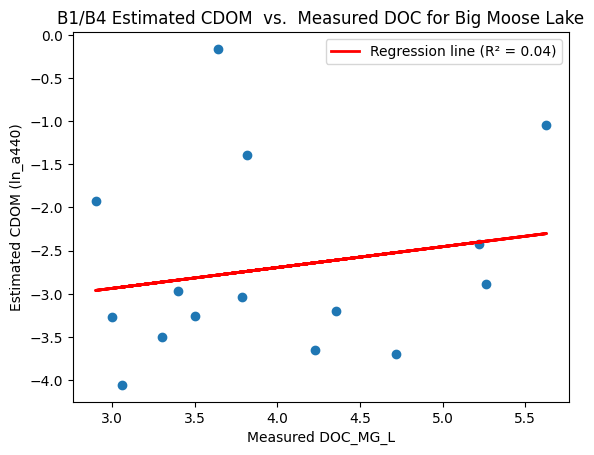

In [131]:
import numpy as np
#--------------------------------------EQUATION---------------------------------------
# Band Ratio for Landsat 5 Level 1

# Calculate the B1/B4 ratio
LT5_L1_df['B1/B4'] = LT5_L1_df['B1_mean'] / LT5_L1_df['B4_mean']

#--------------------------------------PLOT---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert DATE_SMP columns to datetime
LT5_L1_df['DATE'] = pd.to_datetime(LT5_L1_df['DATE'])
LTM_insitu_df['DATE_SMP'] = pd.to_datetime(LTM_insitu_df['DATE_SMP'])

# Extract the year from the DATE_SMP columns
LT5_L1_df['YEAR'] = LT5_L1_df['DATE'].dt.year
LTM_insitu_df['YEAR'] = LTM_insitu_df['DATE_SMP'].dt.year

# Merge dataframes on the 'YEAR' column
merged_df = pd.merge(LT5_L1_df, LTM_insitu_df, on='YEAR', suffixes=('_LT5', '_LTM'))

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['DOC_MG_L', 'B1/B4'])

# Extract the dependent and independent variables
X = merged_df['DOC_MG_L'].values.reshape(-1, 1)
y = merged_df['B1/B4'].values

# Create a linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Predict y values using the model
y_pred = regression_model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R^2 and RMSE
print("R^2:", r2)
print("RMSE:", rmse)

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression line (R² = {r2:.2f})')

# Plot measured DOC_MG_L against ln_a440
plt.scatter(merged_df['DOC_MG_L'], merged_df['B1/B4'])
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Measured DOC_MG_L')
plt.ylabel('Estimated CDOM (ln_a440)')
plt.title('B1/B4 Estimated CDOM  vs.  Measured DOC for Big Moose Lake')
plt.legend()
plt.show()

## Landsat 5 Level 2 vs LTM In-situ Data

R^2: 0.295683323924261
RMSE: 0.1648771659454684


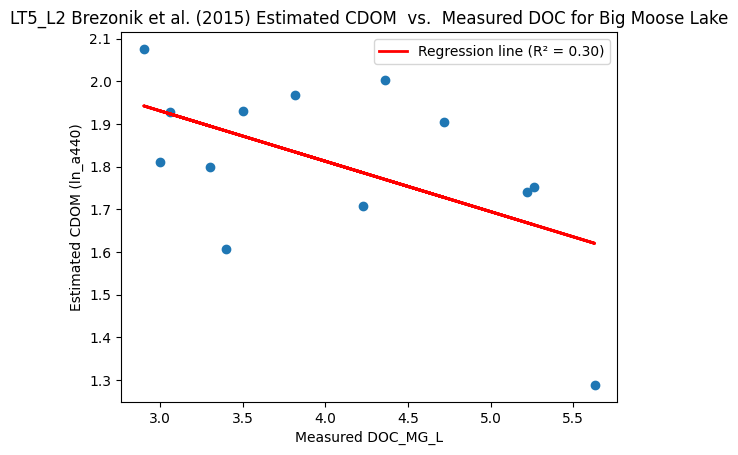

In [128]:
import numpy as np
#--------------------------------------EQUATION---------------------------------------
# Brezonik et al. (2015)

# Coefficients
a1 = 1.441
a2 = -0.841

# Calculate the natural logarithm of B1/B4 ratio
LT5_L2_df['ln_B1_B4'] = np.log(LT5_L2_df['blue_mean'] / LT5_L2_df['nir_mean'])

# Apply the equation to estimate ln(a440)
LT5_L2_df['ln_a440'] = a1 + a2 * LT5_L2_df['ln_B1_B4']

# # Convert ln(a440) back to a440 (if needed)
# LT5_L2_df['a440'] = np.exp(LT5_L2_df['ln_a440'])

#--------------------------------------PLOT---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert DATE_SMP columns to datetime
LT5_L2_df['DATE_SMP'] = pd.to_datetime(LT5_L2_df['DATE_SMP'])
LTM_insitu_df['DATE_SMP'] = pd.to_datetime(LTM_insitu_df['DATE_SMP'])

# Extract the year from the DATE_SMP columns
LT5_L2_df['YEAR'] = LT5_L2_df['DATE_SMP'].dt.year
LTM_insitu_df['YEAR'] = LTM_insitu_df['DATE_SMP'].dt.year

# Merge dataframes on the 'YEAR' column
merged_df = pd.merge(LT5_L2_df, LTM_insitu_df, on='YEAR', suffixes=('_LT5', '_LTM'))

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['DOC_MG_L', 'ln_a440'])

# Extract the dependent and independent variables
X = merged_df['DOC_MG_L'].values.reshape(-1, 1)
y = merged_df['ln_a440'].values

# Create a linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Predict y values using the model
y_pred = regression_model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R^2 and RMSE
print("R^2:", r2)
print("RMSE:", rmse)

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression line (R² = {r2:.2f})')

# Plot measured DOC_MG_L against ln_a440
plt.scatter(merged_df['DOC_MG_L'], merged_df['ln_a440'])
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Measured DOC_MG_L')
plt.ylabel('Estimated CDOM (ln_a440)')
plt.title('LT5_L2 Brezonik et al. (2015) Estimated CDOM  vs.  Measured DOC for Big Moose Lake')
plt.legend()
plt.show()

## Landsat 5 Level 1 Acolite Corrected vs LTM In-situ Data

R^2: 0.001195254797923595
RMSE: 0.3735350381969845


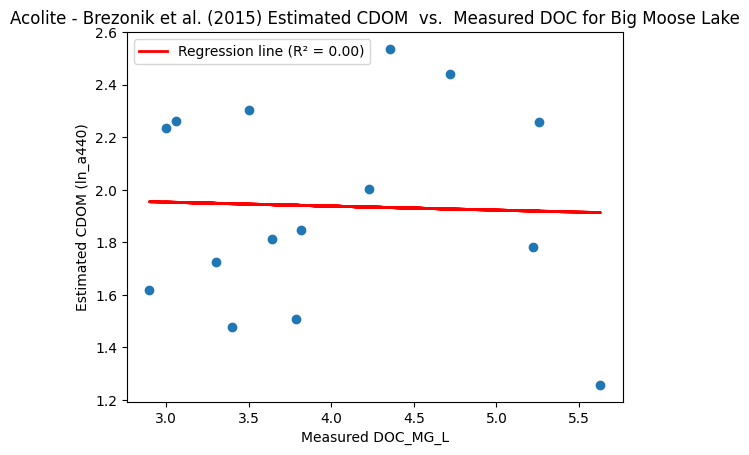

In [133]:
import numpy as np
#--------------------------------------EQUATION---------------------------------------
# Brezonik et al. (2015)

# Coefficients
a1 = 1.441
a2 = -0.841

# Calculate the natural logarithm of B1/B4 ratio
LT5_L1_acolite_df['ln_B1_B4'] = np.log(LT5_L1_acolite_df['B1_mean'] / LT5_L1_acolite_df['B4_mean'])

# Apply the equation to estimate ln(a440)
LT5_L1_acolite_df['ln_a440'] = a1 + a2 * LT5_L1_acolite_df['ln_B1_B4']

# # Convert ln(a440) back to a440 (if needed)
# LT5_L1_acolite_df['a440'] = np.exp(LT5_L1_acolite_df['ln_a440'])

#--------------------------------------PLOT---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert DATE_SMP columns to datetime
LT5_L1_acolite_df['DATE'] = pd.to_datetime(LT5_L1_acolite_df['DATE'])
LTM_insitu_df['DATE_SMP'] = pd.to_datetime(LTM_insitu_df['DATE_SMP'])

# Extract the year from the DATE_SMP columns
LT5_L1_acolite_df['YEAR'] = LT5_L1_acolite_df['DATE'].dt.year
LTM_insitu_df['YEAR'] = LTM_insitu_df['DATE_SMP'].dt.year

# Merge dataframes on the 'YEAR' column
merged_df = pd.merge(LT5_L1_acolite_df, LTM_insitu_df, on='YEAR', suffixes=('_LT5', '_LTM'))

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['DOC_MG_L', 'ln_a440'])

# Extract the dependent and independent variables
X = merged_df['DOC_MG_L'].values.reshape(-1, 1)
y = merged_df['ln_a440'].values

# Create a linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Predict y values using the model
y_pred = regression_model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R^2 and RMSE
print("R^2:", r2)
print("RMSE:", rmse)

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression line (R² = {r2:.2f})')

# Plot measured DOC_MG_L against ln_a440
plt.scatter(merged_df['DOC_MG_L'], merged_df['ln_a440'])
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Measured DOC_MG_L')
plt.ylabel('Estimated CDOM (ln_a440)')
plt.title('Acolite - Brezonik et al. (2015) Estimated CDOM  vs.  Measured DOC for Big Moose Lake')
plt.legend()
plt.show()

## Landsat 5 Level 1 FLAASH Corrected vs LTM In-situ Data

R^2: 0.06968975397199695
RMSE: 0.7795106173755368


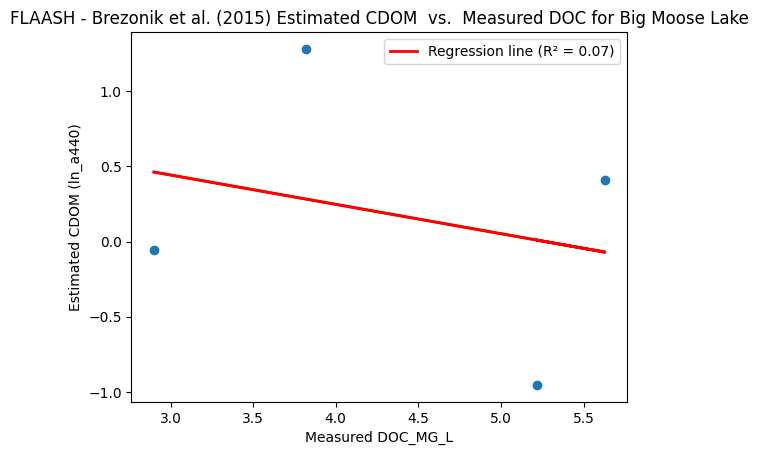

In [152]:
import numpy as np
#--------------------------------------EQUATION---------------------------------------
# Brezonik et al. (2015)

# Since the FLAASH values are largly negative for B4, the original formula leads to NaN values
# Coefficients
a1 = 1.441
a2 = -0.841

# Calculate the natural logarithm of B1/B4 ratio
LT5_L1_FLAASH_df['ln_B1_B4'] = np.log(LT5_L1_FLAASH_df['B1_mean'] / LT5_L1_FLAASH_df['B4_mean'])

# Apply the equation to estimate ln(a440)
LT5_L1_FLAASH_df['ln_a440'] = a1 + a2 * LT5_L1_FLAASH_df['ln_B1_B4']

# # Convert ln(a440) back to a440 (if needed)
# LT5_L1_FLAASH_df['a440'] = np.exp(LT5_L1_FLAASH_df['ln_a440'])

#--------------------------------------PLOT---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert DATE_SMP columns to datetime
LT5_L1_FLAASH_df['DATE'] = pd.to_datetime(LT5_L1_FLAASH_df['DATE'])
LTM_insitu_df['DATE_SMP'] = pd.to_datetime(LTM_insitu_df['DATE_SMP'])

# Extract the year from the DATE_SMP columns
LT5_L1_FLAASH_df['YEAR'] = LT5_L1_FLAASH_df['DATE'].dt.year
LTM_insitu_df['YEAR'] = LTM_insitu_df['DATE_SMP'].dt.year

# Merge dataframes on the 'YEAR' column
merged_df = pd.merge(LT5_L1_FLAASH_df, LTM_insitu_df, on='YEAR', suffixes=('_LT5', '_LTM'))

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['DOC_MG_L', 'ln_a440'])

# Extract the dependent and independent variables
X = merged_df['DOC_MG_L'].values.reshape(-1, 1)
y = merged_df['ln_a440'].values

# Create a linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Predict y values using the model
y_pred = regression_model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R^2 and RMSE
print("R^2:", r2)
print("RMSE:", rmse)

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression line (R² = {r2:.2f})')

# Plot measured DOC_MG_L against ln_a440
plt.scatter(merged_df['DOC_MG_L'], merged_df['ln_a440'])
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Measured DOC_MG_L')
plt.ylabel('Estimated CDOM (ln_a440)')
plt.title('FLAASH - Brezonik et al. (2015) Estimated CDOM  vs.  Measured DOC for Big Moose Lake')
plt.legend()
plt.show()

In [154]:
LT5_L1_FLAASH_df # There are NaN values in the reuslitng columns after equation is applied, the values must be rescaled so that B4 does not have negative values

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B7_mean,DATE,ln_B1_B4,ln_a440,YEAR,a440
0,0.348002,0.191963,0.133832,-0.123819,0.017034,0.030407,1985-07-13,NaN,NaN,1985,NaN
1,0.312399,0.149088,0.072647,-0.131301,-0.017724,-0.002708,1986-07-16,NaN,NaN,1986,NaN
2,0.441607,0.296638,0.216759,0.074359,0.006879,0.006955,1989-07-24,1.781513,-0.057253,1989,0.944355
3,0.427650,0.228667,0.142419,-0.074177,0.008622,0.016064,1990-07-27,NaN,NaN,1990,NaN
4,0.335884,0.184130,0.116476,-0.092245,0.016544,0.023812,1991-07-30,NaN,NaN,1991,NaN
5,0.301361,0.156001,0.111673,-0.124822,0.009276,0.021486,1996-07-11,NaN,NaN,1996,NaN
6,0.265070,0.129855,0.073381,-0.144567,-0.007479,0.008717,1997-07-30,NaN,NaN,1997,NaN
7,0.311695,0.155480,0.097918,-0.155503,-0.002657,0.014612,2001-07-09,NaN,NaN,2001,NaN
8,0.347497,0.171095,0.105716,-0.070485,0.009457,0.019664,2003-07-15,NaN,NaN,2003,NaN
9,0.418686,0.330425,0.259663,0.347091,0.105693,0.076088,2005-07-04,0.187534,1.283284,2005,3.608469


R^2: 0.020066727580550392
RMSE: 0.12985951828694903


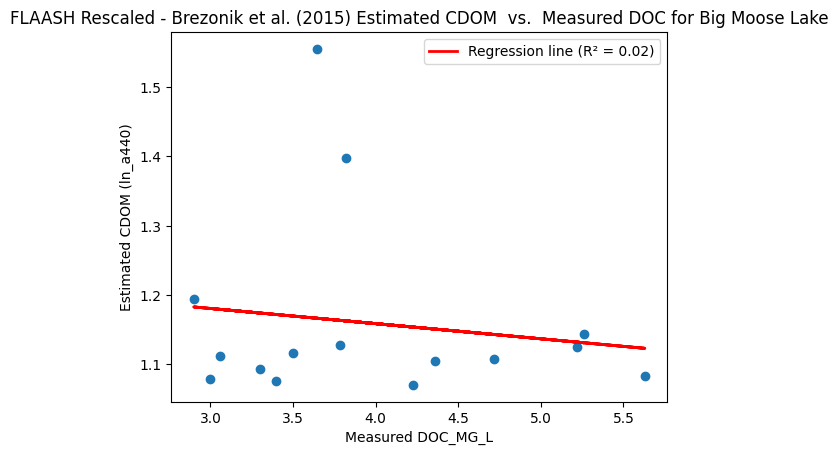

In [153]:
import numpy as np
#--------------------------------------EQUATION---------------------------------------
# Brezonik et al. (2015)

# Since the FLAASH values are largly negative for B4, the original formula leads to NaN values
# Coefficients
a1 = 1.441
a2 = -0.841

# Calculate the natural logarithm of B1/B4 ratio
LT5_L1_FLAASH_rescaled_df['ln_B1_B4'] = np.log(LT5_L1_FLAASH_rescaled_df['B1_mean'] / LT5_L1_FLAASH_rescaled_df['B4_mean'])

# Apply the equation to estimate ln(a440)
LT5_L1_FLAASH_rescaled_df['ln_a440'] = a1 + a2 * LT5_L1_FLAASH_rescaled_df['ln_B1_B4']

# # Convert ln(a440) back to a440 (if needed)
# LT5_L1_FLAASH_rescaled_df['a440'] = np.exp(LT5_L1_FLAASH_rescaled_df['ln_a440'])

#--------------------------------------PLOT---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert DATE_SMP columns to datetime
LT5_L1_FLAASH_rescaled_df['DATE'] = pd.to_datetime(LT5_L1_FLAASH_rescaled_df['DATE'])
LTM_insitu_df['DATE_SMP'] = pd.to_datetime(LTM_insitu_df['DATE_SMP'])

# Extract the year from the DATE_SMP columns
LT5_L1_FLAASH_rescaled_df['YEAR'] = LT5_L1_FLAASH_rescaled_df['DATE'].dt.year
LTM_insitu_df['YEAR'] = LTM_insitu_df['DATE_SMP'].dt.year

# Merge dataframes on the 'YEAR' column
merged_df = pd.merge(LT5_L1_FLAASH_rescaled_df, LTM_insitu_df, on='YEAR', suffixes=('_LT5', '_LTM'))

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['DOC_MG_L', 'ln_a440'])

# Extract the dependent and independent variables
X = merged_df['DOC_MG_L'].values.reshape(-1, 1)
y = merged_df['ln_a440'].values

# Create a linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Predict y values using the model
y_pred = regression_model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R^2 and RMSE
print("R^2:", r2)
print("RMSE:", rmse)

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression line (R² = {r2:.2f})')

# Plot measured DOC_MG_L against ln_a440
plt.scatter(merged_df['DOC_MG_L'], merged_df['ln_a440'])
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Measured DOC_MG_L')
plt.ylabel('Estimated CDOM (ln_a440)')
plt.title('FLAASH Rescaled - Brezonik et al. (2015) Estimated CDOM  vs.  Measured DOC for Big Moose Lake')
plt.legend()
plt.show()